In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [4]:
def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints): # (unmodeled) data
  w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                scale=2.0 * tf.ones([data_dim, latent_dim]),
                name="w")  # parameter
  z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                scale=tf.ones([latent_dim, num_datapoints]), 
                name="z")  # parameter
  x = ed.Normal(loc=tf.matmul(w, z),
                scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
                name="x")  # (modeled) data
  return x, (w, z)

log_joint = ed.make_log_joint_fn(probabilistic_pca)

### Generate Toy Data

In [5]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

model = probabilistic_pca(data_dim=data_dim,
                          latent_dim=latent_dim,
                          num_datapoints=num_datapoints,
                          stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_train, (actual_w, actual_z) = sess.run(model)

print("Principal axes:")
print(actual_w)

Principal axes:
[[-3.054664]
 [ 4.681571]]


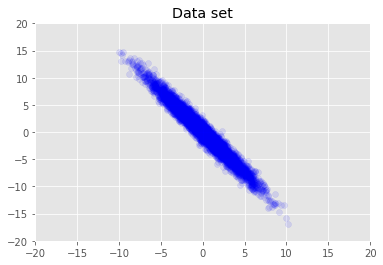

In [6]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.title("Data set")
plt.show()

### MAP

In [7]:
tf.reset_default_graph()

w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)


def target(w, z):
  """Unnormalized target density as a function of the parameters."""
  return log_joint(data_dim=data_dim,
                   latent_dim=latent_dim,
                   num_datapoints=num_datapoints,
                   stddv_datapoints=stddv_datapoints,
                   w=w, z=z, x=x_train)


energy = -target(w, z)

optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
train = optimizer.minimize(energy)

init = tf.global_variables_initializer()

t = []

num_epochs = 200

with tf.Session() as sess:
  sess.run(init)

  for i in range(num_epochs):
    sess.run(train)
    if i % 5 == 0:
      cE, cw, cz = sess.run([energy, w, z])
      t.append(cE)

  w_inferred_map = sess.run(w)
  z_inferred_map = sess.run(z)

In [8]:
x = range(1, num_epochs, 5)

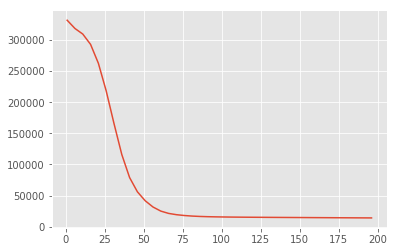

In [9]:
plt.plot(x, t)

MAP-estimated axes:
[[-2.1671772]
 [ 3.325361 ]]


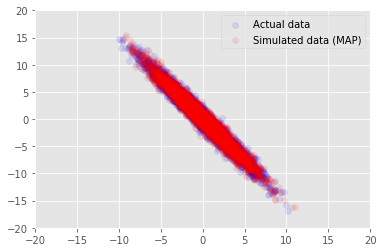

In [10]:
print("MAP-estimated axes:")
print(w_inferred_map)

def replace_latents(w=actual_w, z=actual_z):

  def interceptor(rv_constructor, *rv_args, **rv_kwargs):
    """Replaces the priors with actual values to generate samples from."""
    name = rv_kwargs.pop("name")
    if name == "w":
      rv_kwargs["value"] = w
    elif name == "z":
      rv_kwargs["value"] = z
    return rv_constructor(*rv_args, **rv_kwargs)

  return interceptor

with ed.interception(replace_latents(w_inferred_map, z_inferred_map)):
  generate = probabilistic_pca(
      data_dim=data_dim, latent_dim=latent_dim,
      num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_generated, _ = sess.run(generate)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

# Variational Inference

In [11]:
tf.reset_default_graph()

def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
  qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
  qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
  return qw, qz


log_q = ed.make_log_joint_fn(variational_model)

def target_q(qw, qz):
  return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
               qz_mean=qz_mean, qz_stddv=qz_stddv,
               qw=qw, qz=qz)


qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))

qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                           qz_mean=qz_mean, qz_stddv=qz_stddv)

energy = target(qw, qz)
entropy = -target_q(qw, qz)

elbo = energy + entropy


optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
train = optimizer.minimize(-elbo)

init = tf.global_variables_initializer()

t = []

num_epochs = 100

with tf.Session() as sess:
  sess.run(init)

  for i in range(num_epochs):
    sess.run(train)
    if i % 5 == 0:
      t.append(sess.run([elbo]))

  w_mean_inferred = sess.run(qw_mean)
  w_stddv_inferred = sess.run(qw_stddv)
  z_mean_inferred = sess.run(qz_mean)
  z_stddv_inferred = sess.run(qz_stddv)

Inferred axes:
[[-1.8487215]
 [ 2.856971 ]]
Standard Deviation:
[[0.01174122]
 [0.01239337]]


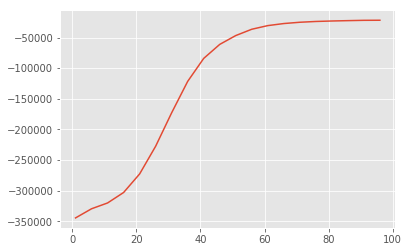

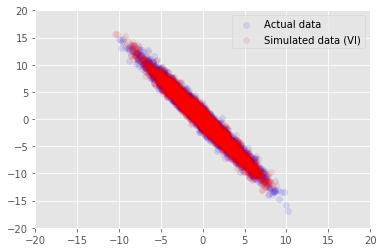

In [12]:
print("Inferred axes:")
print(w_mean_inferred)
print("Standard Deviation:")
print(w_stddv_inferred)

plt.plot(range(1, num_epochs, 5), t)
plt.show()

with ed.interception(replace_latents(w_mean_inferred, z_mean_inferred)):
  generate = probabilistic_pca(
      data_dim=data_dim, latent_dim=latent_dim,
      num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints)

with tf.Session() as sess:
  x_generated, _ = sess.run(generate)

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()